In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

In [2]:

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    'text.latex.preamble': r"\usepackage{amsmath}"

}
plt.rcParams.update(tex_fonts)

In [24]:
settings_piflux = [
    "?name=piflux-2?J_pm=0.333?B=[0.000,0.000,0.000].jld",
    # "?name=piflux-2?J_pm=0.333?B=[0.000,0.042,0.042].jld",
    # "?name=piflux-2?J_pm=0.333?B=[0.035,0.035,0.035].jld"
    "?name=piflux-2?J_pm=0.333?B=[0.000,0.071,0.071].jld",
    "?name=piflux-2?J_pm=0.333?B=[0.058,0.058,0.058].jld"
]

settings_pipi00 = [
    "?name=pipi00+1e-4?J_pm=-0.050?B=[0.000,0.173,0.173].jld",
    "?name=pipi00+1e-4?J_pm=-0.050?B=[0.000,0.260,0.260].jld",
    "?name=pipi00+1e-4?J_pm=-0.050?B=[0.000,0.346,0.346].jld"
]

SAVEPATH = "/Users/alaricsanders/Documents/gh-papers/Experimentally-Tunable-QED-in-DO-QSI/FIG"

SAVEPATH_POSTER = "/Users/alaricsanders/Desktop/figure_out"


In [5]:
# general-purpose plot function


def plot_all(settings, titles=None, cmap=matplotlib.cm.magma, normalise_intensity=False):
    fig, Ax = plt.subplots(nrows=3, ncols=len(settings)*2,sharex=False, sharey=False,width_ratios=[3,0.5]*len(settings))

    # autorange sweep
    spinon_max_E=-float("inf")
    intens_max_E=-float("inf")
    intens_max_Spm=-float("inf")
    intens_max_Smagnetic=-float("inf")
    
    for these_settings in settings:
        intensity_file = h5py.File("output/SQW"+these_settings)
        fsp = h5py.File("output/spinons"+these_settings)
        spinon_max_E = max(spinon_max_E, np.max(fsp["spinon_dispersion"]["bands"]))
        intens_max_E = max(intens_max_E, np.max(intensity_file["intensity"]["W"]))
        intens_max_Spm = max(intens_max_Spm, np.max(intensity_file["intensity"]["Spm"]["re_"]) )
        intens_max_Smagnetic = max(intens_max_Smagnetic, np.max(np.ma.masked_invalid(intensity_file["intensity"]["Smagnetic"])))
    
    
    for i, these_settings in enumerate(settings):
        intensity_file = h5py.File("output/SQW"+these_settings)
    
        intens=intensity_file["intensity"]
        Ax[1][2*i].pcolormesh(intens["tau"], intens["W"], intens["Spm"]['re_'], 
                              shading='nearest',
                              rasterized=True, 
                              vmax=intens_max_Spm if normalise_intensity else None,
                              cmap=cmap
                             )
        Ax[2][2*i].pcolormesh(intens["tau"], intens["W"], intens["Smagnetic"],shading='nearest',
                              rasterized=True, 
                              vmax=intens_max_Smagnetic if normalise_intensity else None,
                              cmap=cmap
                             )
        
    
        for a in (Ax[1][2*i], Ax[2][2*i]):
            # a.plot(np.array(intens["tau"]), intens["bounds"][0], color='w',lw=0.4)
            # a.plot(np.array(intens["tau"]), intens["bounds"][1], color='w',lw=0.4)
            a.set_facecolor(cmap(0))
    
    
        Ax[1][2*i].set_xticks(intens["ticks_tau"], labels=[])
        Ax[2][2*i].set_xticks(intens["ticks_tau"], labels=["$%s$"%(x.decode("UTF8")) for x in intens["ticks_label"]])
                  
    
        fsp = h5py.File("output/spinons"+these_settings)
        spinon_intens = fsp["spinon_dispersion"]
        Ax[0][2*i].plot(np.array(spinon_intens["tau"]), np.array(spinon_intens["bands"]).T, color='k', lw=0.4)
        Ax[0][2*i].set_ylim([0,spinon_max_E+0.05])
        Ax[0][2*i].set_xticks(spinon_intens["ticks_tau"], labels=[])
        Ax[0][2*i].set_xlim( [np.min(spinon_intens["ticks_tau"]), np.max(spinon_intens["ticks_tau"])])
    
        fint = h5py.File("output/integrated"+these_settings)
        W = np.array(fint['intensity']['W'])
        Ax[1][2*i+1].plot(fint['intensity']['Spm']['re_'], W,color='k')
        Ax[2][2*i+1].plot(np.array(fint['intensity']['Smagnetic']), W,color='k')
        
        
        for a in [Ax[1][2*i+1], Ax[2][2*i+1]]:
        # Ax[1][2*i+1].set_ylim([min(W),max(W)])
        # Ax[2][2*i+1].set_ylim([min(W),max(W)])
            a.axis('off')
    
        for a in [Ax[1][2*i+1], Ax[1][2*i], Ax[2][2*i+1], Ax[2][2*i]]:
            a.set_ylim([0,intens_max_E])
    
        for j in range(3):
            Ax[j][2*i+1].set_yticklabels([])
            if i != 0:
                Ax[j][2*i].set_yticklabels([])
                
        
        Ax[0][2*i+1].axis('off')
        for j in [1,2]:
            a = Ax[j][2*i+1]
            a.set_xticks([])
            a.set_yticks([])
            # a.set_xlim([0,489384])
    
        phys = intensity_file["physical_parameters"]
        Bvec = eval(these_settings.split('?')[3][2:-4])
        print(f"Col {i}\n")
        print(f"\tFluxes: {np.mean(phys["emergent_fluxes"],axis=1)/np.pi}π ")
        print(f"\tJ_pm: {phys["Jpm"][()]}")
        print(f"\tB: {Bvec} ")
    
        
        B = np.linalg.norm(Bvec)
        Jpm = settings[i].split('?')[2][5:]

        if titles is None:
            Ax[0][2*i].set_title(r"$\|\boldsymbol{B}\|$=%.2f $J_{\pm}$=%s" % (B, Jpm) ,fontsize=10)
        else:
            Ax[0][2*i].set_title(titles[i])
    
    for row in Ax:
        row[0].set_ylabel(r"$\omega/J_{yy}$")

    fig.tight_layout()
    
    return fig, Ax
    


In [6]:
## Form for posters and presentations

def plot_all_magnetic_only(settings, titles=None, cmap=matplotlib.cm.magma, normalise_intensity=False):
    fig, Ax = plt.subplots(nrows=2, ncols=len(settings)*2,sharex=False, sharey=False,width_ratios=[3,0.5]*len(settings))

    # autorange sweep
    spinon_max_E=-float("inf")
    intens_max_E=-float("inf")
    intens_max_Spm=-float("inf")
    intens_max_Smagnetic=-float("inf")
    
    for these_settings in settings:
        intensity_file = h5py.File("output/SQW"+these_settings)
        fsp = h5py.File("output/spinons"+these_settings)
        spinon_max_E = max(spinon_max_E, np.max(fsp["spinon_dispersion"]["bands"]))
        intens_max_E = max(intens_max_E, np.max(intensity_file["intensity"]["W"]))
        intens_max_Spm = max(intens_max_Spm, np.max(intensity_file["intensity"]["Spm"]["re_"]) )
        intens_max_Smagnetic = max(intens_max_Smagnetic, np.max(np.ma.masked_invalid(intensity_file["intensity"]["Smagnetic"])))
    
    
    for i, these_settings in enumerate(settings):
        intensity_file = h5py.File("output/SQW"+these_settings)
    
        intens=intensity_file["intensity"]
       
        Ax[1][2*i].pcolormesh(intens["tau"], intens["W"], intens["Smagnetic"],shading='nearest',
                              rasterized=True, 
                              vmax=intens_max_Smagnetic if normalise_intensity else None,
                              cmap=cmap
                             )
        
        Ax[1][2*i].set_facecolor(cmap(0))
        Ax[1][2*i].set_xticks(intens["ticks_tau"], labels=["$%s$"%(x.decode("UTF8")) for x in intens["ticks_label"]])
                  
    
        fsp = h5py.File("output/spinons"+these_settings)
        spinon_intens = fsp["spinon_dispersion"]
        Ax[0][2*i].plot(np.array(spinon_intens["tau"]), np.array(spinon_intens["bands"]).T, color='k', lw=0.4)
        Ax[0][2*i].set_ylim([0,spinon_max_E+0.05])
        Ax[0][2*i].set_xticks(spinon_intens["ticks_tau"], labels=[])
        Ax[0][2*i].set_xlim( [np.min(spinon_intens["ticks_tau"]), np.max(spinon_intens["ticks_tau"])])
    
        fint = h5py.File("output/integrated"+these_settings)
        W = np.array(fint['intensity']['W'])
        Ax[1][2*i+1].plot(np.array(fint['intensity']['Smagnetic']), W,color='k')
        
        Ax[1][2*i+1].axis('off')
    
        for a in [Ax[1][2*i+1], Ax[1][2*i]]:
            a.set_ylim([0,intens_max_E])
    
        for j in range(2):
            Ax[j][2*i+1].set_yticklabels([])
            if i != 0:
                Ax[j][2*i].set_yticklabels([])
                
        
        Ax[0][2*i+1].axis('off')
        
        a = Ax[1][2*i+1]
        a.set_xticks([])
        a.set_yticks([])
    
        phys = intensity_file["physical_parameters"]
        Bvec = eval(these_settings.split('?')[3][2:-4])
        print(f"Col {i}\n")
        print(f"\tFluxes: {np.mean(phys["emergent_fluxes"],axis=1)/np.pi}π ")
        print(f"\tJ_pm: {phys["Jpm"][()]}")
        print(f"\tB: {Bvec} ")
    
        
        B = np.linalg.norm(Bvec)
        Jpm = settings[i].split('?')[2][5:]

        if titles is None:
            Ax[0][2*i].set_title(r"$\|\boldsymbol{B}\|$=%.2f $J_{\pm}$=%s" % (B, Jpm) ,fontsize=10)
        else:
            Ax[0][2*i].set_title(titles[i])
    
    for row in Ax:
        row[0].set_ylabel(r"$\omega/J_{yy}$")
    
    fig.tight_layout()

    return fig, Ax

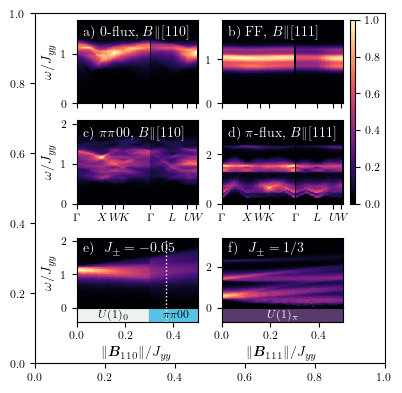

In [7]:
# FINAL PLOT FOR MAIN FIGURE
fig = plt.figure(figsize=(3.5,3.5))
subfigs = fig.subfigures(2, 1, [0,0,1,1],hspace=0.07, height_ratios=[2, 1.2])
Ax = subfigs[0].subplots(2, 2, sharex=True, sharey=False)
Ax2 = subfigs[1].subplots(2, 2, sharex=True, height_ratios=[2, 0.4])

#  110   111
# [ 0flux , FF ]
# [ ππ00, πflux ]
# [ ππ00-tune, πflux-tune]

settings=[
    "?name=0flux?J_pm=-0.046?B=[0.000,0.042,0.042].jld",
    # "?name=FF-kludge?J_pm=-0.050?B=[0.224,0.224,0.224].jld",
    "?name=FF-kludge?J_pm=-0.010?B=[0.100,0.100,0.100].jld",
    "?name=pipi00+1e-4?J_pm=-0.050?B=[0.000,0.260,0.260].jld",
    "?name=piflux-2?J_pm=0.333?B=[0.058,0.058,0.058].jld"
]

settings_sweep = [
    # "int_fieldsweep?name=pipi00-along?J_pm=-0.050?B=[0.577,0.577,0.577].jld",
    # "int_fieldsweep?name=pipi00-along?J_pm=-0.050?B=[0.577,0.577,0.577].jld",
    "int_fieldsweep?name=TEST_mix_pipi00?J_pm=-0.050?B=[0.000,0.000,0.000].jld",
    "int_fieldsweep?name=piflux-along?J_pm=0.333?B=[0.577,0.577,0.577].jld"
]
    

# cmap=matplotlib.cm.gnuplot
cmap=matplotlib.cm.magma
cmap2=cmap

for j, (these_settings, ax) in enumerate(zip(settings, Ax.ravel())):
    intensity_file = h5py.File("output/SQW"+these_settings)
    intens=intensity_file["intensity"]
            
    c1 = ax.pcolormesh(intens["tau"], intens["W"], intens["Smagnetic"],shading='nearest',
                                  rasterized=True, 
                                  cmap=cmap
                                 )
    ax.set_facecolor(cmap(0))
    ax.set_xticks(intens["ticks_tau"], labels=[])

labels = [r'a) 0-flux, $B\|[110]$',r'b) FF, $B\|[111]$',r'c) $\pi\pi00$, $B\|[110]$',r'd) $\pi$-flux, $B\|[111]$']
# labels = [r'a) 0-flux',r'b) FF',r'c) $\pi\pi00$',r'd) $\pi$-flux']

for label, ax in zip(labels, Ax.ravel()):
    ax.text(0.05,0.8, label, transform=ax.transAxes, color='white',)
    
Ax[0][0].set_ylim([0,1.7])
Ax[0][1].set_ylim([0,1.9])

for a in [Ax[1][0], Ax2[0][0] ]:
    a.set_ylim([0,2.1])
for a in [Ax[1][1], Ax2[0][1] ]:
    a.set_ylim([0,3.4])

for ax in Ax[1]:
    ax.set_xticks(intens["ticks_tau"], labels=["$%s$"%(x.decode("UTF8")) for x in intens["ticks_label"]])

for s, ax, ax2 in zip(settings_sweep, Ax2[0], Ax2[1]):
    data = h5py.File("output/"+s)
    intens = data['integrated_intensity']
    # print(intens.keys())
    c2 = ax.pcolormesh( intens['magnetic_field_strengths'], intens['W'], intens['Smagnetic'],
                    rasterized=True, 
                       shading='nearest',
                       cmap=cmap2)
    ax.set_facecolor(cmap2(0))
    ax2.set_xlim([np.min(intens['magnetic_field_strengths']), np.max(intens['magnetic_field_strengths'])])

for row in Ax2:
    row[0].axvline(np.linalg.norm([0.000,0.260,0.260]),color='w',lw=1,ls=':')

    # row[1].axvline(np.linalg.norm([0.058,0.058,0.058]),color='w',lw=1,ls=':')


# Ax[0][0].set_title('110 field')
# Ax[0][1].set_title('111 field')

# ax2labels = [r'e) $B\| [110]$', r'f)~~~ $B\|[111]$']
ax2labels = [r'e) ~$J_\pm = -0.05$', r'f) ~$J_\pm = 1/3$']

for l,ax in zip(ax2labels,Ax2[0]):
    ax.text(0.05,0.8, l, transform=ax.transAxes, color='white',)


Ax[0][0].set_ylabel(r"$\omega/J_{yy}$")
Ax[1][0].set_ylabel(r"$\omega/J_{yy}$")
Ax2[0][0].set_ylabel(r"$\omega/J_{yy}$")

phase_colors = dict(
flux0="#EDF2EF",
ππ00="#57C4E5",
πflux="#593a6d",
)


SAVEPATH_FINAL = "/Users/alaricsanders/Documents/gh-papers/Experimentally-Tunable-QED-in-DO-QSI/FIG"
# fig.tight_layout()
top_top = 0.97
top_bottom = 0.1
Left = 0.12
Right = 0.88
subfigs[0].subplots_adjust(top=top_top,right=Right,left=Left,bottom=top_bottom)
cax = subfigs[0].add_axes([0.9,0.1,0.015,top_top-top_bottom])
subfigs[0].colorbar(matplotlib.cm.ScalarMappable(cmap=cmap), orientation='vertical', cax=cax)

# Ax2[0][0].axvline(,color='green',lw=1)
bottom_top = 0.99
bottom_bottom = 0.33
# cax2 = subfigs[1].add_axes([0.9,bottom_bottom,0.02,bottom_top-bottom_bottom])
# subfigs[1].colorbar(matplotlib.cm.ScalarMappable(cmap=cmap2), orientation='vertical', cax=cax2)
subfigs[1].subplots_adjust(top=bottom_top,right=Right,left=Left,bottom=bottom_bottom,hspace=0)

for a in Ax2[1]:
    a.set_yticks([])
    a.set_ylim([0,1])

Bmin = np.sqrt(-9*-0.05/5)
Ax2[1][0].add_patch(matplotlib.patches.Rectangle((0,0), Bmin, 1, color=phase_colors['flux0']))
Ax2[1][0].text(Bmin/2,0.5,r"$U(1)_0$",horizontalalignment="center", verticalalignment="center",fontsize=8)
Ax2[1][0].add_patch(matplotlib.patches.Rectangle((Bmin,0), 1, 1, color=phase_colors['ππ00']))
Ax2[1][0].text(0.41,0.5,r"$\pi\pi00$",horizontalalignment="center", verticalalignment="center",fontsize=8)
Ax2[1][0].set_xlabel(r"$\|\boldsymbol{B}_{110}\|/J_{yy}$")


Ax2[1][1].add_patch(matplotlib.patches.Rectangle((0,0), 1, 1, color=phase_colors['πflux']))
Ax2[1][1].text(0.25,0.5,r"$U(1)_\pi$",horizontalalignment="center", verticalalignment="center",fontsize=8,color='w')
Ax2[1][1].set_xlabel(r"$\|\boldsymbol{B}_{111}\|/J_{yy}$")


# fig.savefig(SAVEPATH_FINAL+"/maintext-spinon.pdf",dpi=300)
fig.add_axes([0,0,1,1]).patch.set_alpha(0)


Col 0

	Fluxes: [0. 0. 0. 0.]π 
	J_pm: -0.046
	B: [0.0, 0.0, 0.0] 
Col 1

	Fluxes: [0. 0. 0. 0.]π 
	J_pm: -0.046
	B: [0.0, 0.071, 0.071] 
Col 2

	Fluxes: [0. 0. 0. 0.]π 
	J_pm: -0.046
	B: [0.058, 0.058, 0.058] 


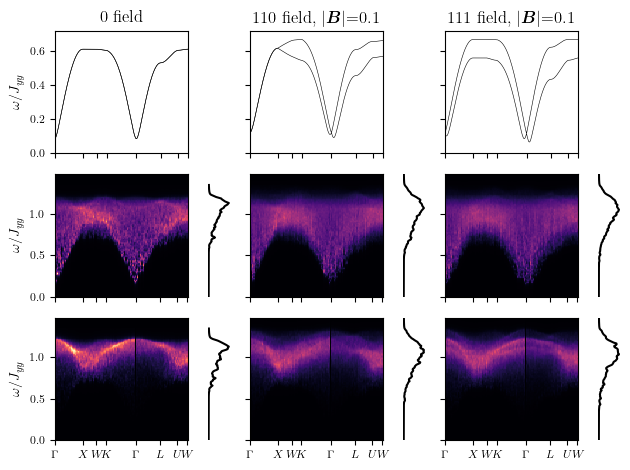

In [34]:
def parsinate_B(s):
    return np.linalg.norm(s.split('[')[-1].split(']')[0].split(','))



settings_0flux_test = [
    "?name=test-0flux?J_pm=-0.046?B=[0.000,0.000,0.000].jld",
    "?name=test-0flux?J_pm=-0.046?B=[0.000,0.071,0.071].jld",
    "?name=test-0flux?J_pm=-0.046?B=[0.058,0.058,0.058].jld"
]


titles = [
    "0 field",
    r"110 field, $|\boldsymbol{B}|$=%.1f"% parsinate_B(settings_0flux_test[1]),
    r"111 field, $|\boldsymbol{B}|$=%.1f"% parsinate_B(settings_0flux_test[1])
]
fig, Ax = plot_all(settings_0flux_test, titles, normalise_intensity=True)
# fig.savefig(SAVEPATH+"/0flux.pdf",dpi=300)
# fig.add_axes([0,0,1,1]).patch.set_alpha(0)

# fig, Ax = plot_all_magnetic_only(settings_0flux, titles, normalise_intensity=True)
# fig.savefig(SAVEPATH_POSTER+"/0flux.pdf",dpi=300)

NameError: name 'load' is not defined

Col 0

	Fluxes: [0. 0. 0. 0.]π 
	J_pm: -0.04
	B: [0.0, 0.0, 0.0] 
Col 1

	Fluxes: [0. 0. 0. 0.]π 
	J_pm: -0.04
	B: [0.0, 0.028, 0.028] 
Col 2

	Fluxes: [0. 0. 0. 0.]π 
	J_pm: -0.04
	B: [0.023, 0.023, 0.023] 


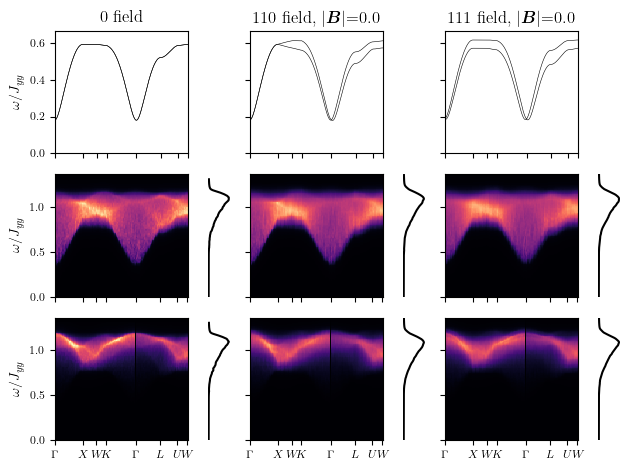

In [38]:


settings = [
    "?name=0flux?J_pm=-0.040?B=[0.000,0.000,0.000].jld",
    "?name=0flux?J_pm=-0.040?B=[0.000,0.028,0.028].jld",
    "?name=0flux?J_pm=-0.040?B=[0.023,0.023,0.023].jld"
]

titles = [
    "0 field",
    r"110 field, $|\boldsymbol{B}|$=%.1f"% parsinate_B(settings[1]),
    r"111 field, $|\boldsymbol{B}|$=%.1f"% parsinate_B(settings[2])
]
fig, Ax = plot_all(settings, titles, normalise_intensity=True)
# fig.savefig(SAVEPATH+"/0flux.pdf",dpi=300)
# fig.add_axes([0,0,1,1]).patch.set_alpha(0)

# fig, Ax = plot_all_magnetic_only(settings_0flux, titles, normalise_intensity=True)
# fig.savefig(SAVEPATH_POSTER+"/0flux.pdf",dpi=300)

Col 0

	Fluxes: [0. 0. 0. 0.]π 
	J_pm: 0.3
	B: [0.0, 0.0, 0.0] 
Col 1

	Fluxes: [0. 0. 0. 0.]π 
	J_pm: 0.3
	B: [0.0, 0.071, 0.071] 
Col 2

	Fluxes: [0. 0. 0. 0.]π 
	J_pm: 0.3
	B: [0.058, 0.058, 0.058] 


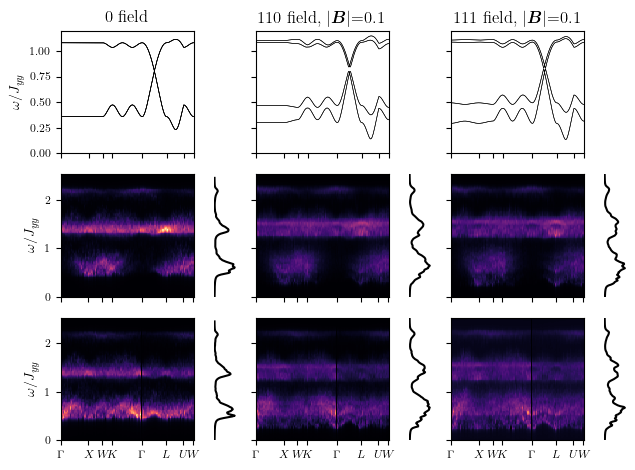

In [33]:
settings = [
    "?name=piflux?J_pm=0.300?B=[0.000,0.000,0.000].jld",
    "?name=piflux?J_pm=0.300?B=[0.000,0.071,0.071].jld",
    "?name=piflux?J_pm=0.300?B=[0.058,0.058,0.058].jld"
]

titles = [
    "0 field",
    r"110 field, $|\boldsymbol{B}|$=%.1f"% parsinate_B(settings[1]),
    r"111 field, $|\boldsymbol{B}|$=%.1f"% parsinate_B(settings[2])
]
fig, Ax = plot_all(settings, titles, normalise_intensity=True)


Col 0

	Fluxes: [0. 0. 0. 0.]π 
	J_pm: -0.05
	B: [0.0, 0.26, 0.26] 
Col 1

	Fluxes: [0. 0. 0. 0.]π 
	J_pm: -0.05
	B: [0.0, 0.346, 0.346] 
Col 0

	Fluxes: [0. 0. 0. 0.]π 
	J_pm: -0.05
	B: [0.0, 0.26, 0.26] 
Col 1

	Fluxes: [0. 0. 0. 0.]π 
	J_pm: -0.05
	B: [0.0, 0.346, 0.346] 


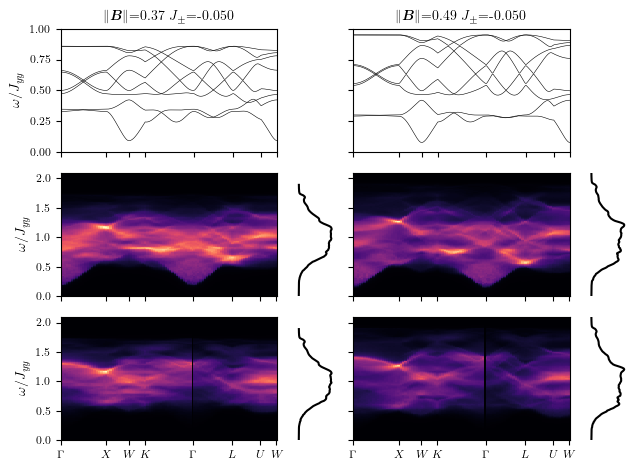

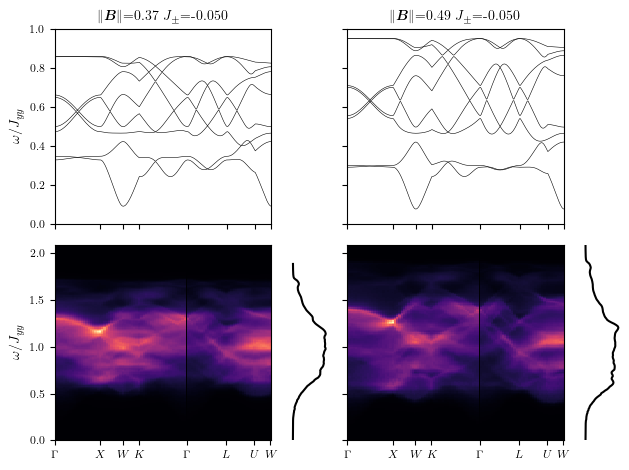

In [64]:
fig, Ax = plot_all(settings_pipi00[1:])
fig.savefig(SAVEPATH+"/pipi00-flux.pdf", dpi=300)

fig, Ax = plot_all_magnetic_only(settings_pipi00[1:])
fig.savefig(SAVEPATH_POSTER+"/pipi00-flux.pdf", dpi=300)



Col 0

	Fluxes: [-0.75  0.25  0.25  0.25]π 
	J_pm: -0.01
	B: [0.085, 0.085, 0.085] 
Col 1

	Fluxes: [-0.75  0.25  0.25  0.25]π 
	J_pm: -0.02
	B: [0.12, 0.12, 0.12] 
Col 2

	Fluxes: [-0.75  0.25  0.25  0.25]π 
	J_pm: -0.03
	B: [0.147, 0.147, 0.147] 
Col 3

	Fluxes: [-0.75  0.25  0.25  0.25]π 
	J_pm: -0.04
	B: [0.17, 0.17, 0.17] 


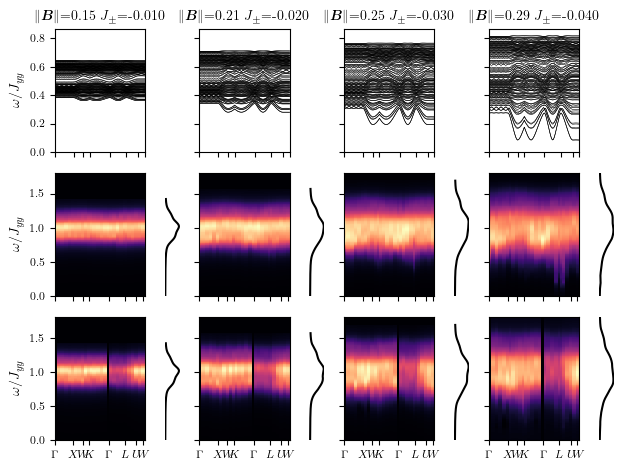

In [39]:

settings = [
    "?name=TEST_FF?J_pm=-0.010?B=[0.085,0.085,0.085].jld",
    "?name=TEST_FF?J_pm=-0.020?B=[0.120,0.120,0.120].jld",
    "?name=TEST_FF?J_pm=-0.030?B=[0.147,0.147,0.147].jld",
    "?name=TEST_FF?J_pm=-0.040?B=[0.170,0.170,0.170].jld"
]

fig, Ax = plot_all(settings)
# fig.savefig(SAVEPATH+"/FF-different_field.pdf",dpi=300)

# fig, Ax = plot_all_magnetic_only(settings)
# fig.savefig(SAVEPATH_POSTER+"/FF-different_field.pdf",dpi=300)

Col 0

	Fluxes: [0.875 0.375 0.375 0.375]π 
	J_pm: -0.01
	B: [0.1, 0.1, 0.1] 
Col 1

	Fluxes: [0.875 0.375 0.375 0.375]π 
	J_pm: -0.02
	B: [0.141, 0.141, 0.141] 
Col 2

	Fluxes: [0.875 0.375 0.375 0.375]π 
	J_pm: -0.05
	B: [0.224, 0.224, 0.224] 
Col 0

	Fluxes: [0.875 0.375 0.375 0.375]π 
	J_pm: -0.01
	B: [0.1, 0.1, 0.1] 
Col 1

	Fluxes: [0.875 0.375 0.375 0.375]π 
	J_pm: -0.02
	B: [0.141, 0.141, 0.141] 
Col 2

	Fluxes: [0.875 0.375 0.375 0.375]π 
	J_pm: -0.05
	B: [0.224, 0.224, 0.224] 


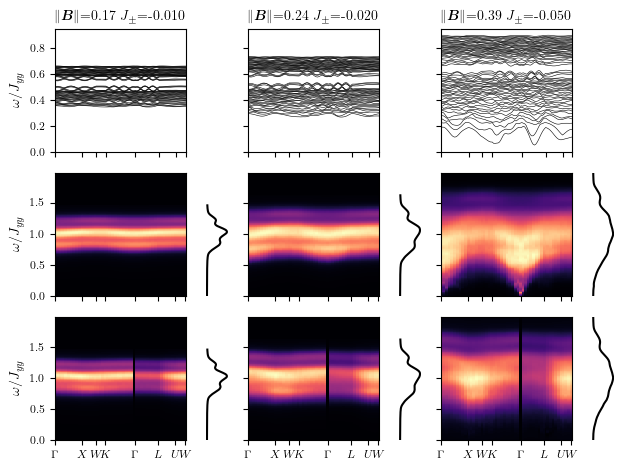

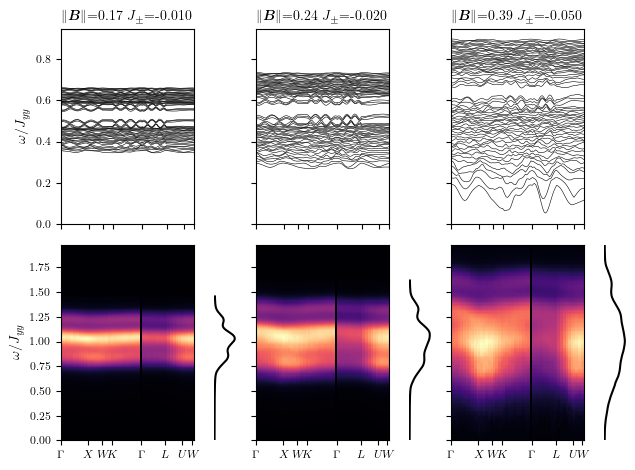

In [11]:
# FRUST FLUX, [7π/8, 3π/8, 3π/8, 3π/8] - flux
settings_FF_kludge = [
    "?name=FF-kludge?J_pm=-0.010?B=[0.100,0.100,0.100].jld",
    "?name=FF-kludge?J_pm=-0.020?B=[0.141,0.141,0.141].jld",
    "?name=FF-kludge?J_pm=-0.050?B=[0.224,0.224,0.224].jld",
    # "?name=FF-kludge?J_pm=-0.100?B=[0.316,0.316,0.316].jld"
]


fig, Ax = plot_all(settings_FF_kludge)
fig.savefig(SAVEPATH+"/FF-7pi8-flux.pdf",dpi=300)

fig, Ax = plot_all_magnetic_only(settings_FF_kludge)
fig.savefig(SAVEPATH_POSTER+"/FF-7pi8-flux.pdf",dpi=300)

Col 0

	Fluxes: [ 0.75 -0.25 -0.25 -0.25]π 
	J_pm: -0.01
	B: [0.085, 0.085, 0.085] 
Col 1

	Fluxes: [ 0.75 -0.25 -0.25 -0.25]π 
	J_pm: -0.02
	B: [0.12, 0.12, 0.12] 
Col 2

	Fluxes: [ 0.75 -0.25 -0.25 -0.25]π 
	J_pm: -0.05
	B: [0.19, 0.19, 0.19] 


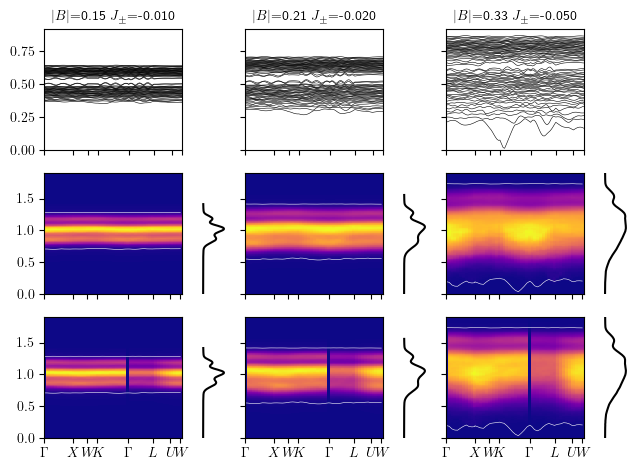

In [488]:
settings_FF_3pi4 = [
"?name=FF-3pi4?J_pm=-0.010?B=[0.085,0.085,0.085].jld",
"?name=FF-3pi4?J_pm=-0.020?B=[0.120,0.120,0.120].jld",
"?name=FF-3pi4?J_pm=-0.050?B=[0.190,0.190,0.190].jld",
# "?name=FF-3pi4?J_pm=-0.100?B=[0.268,0.268,0.268].jld"
]

fig, Ax = plot_all(settings_FF_3pi4)
fig.savefig(SAVEPATH+"/FF-3pi4-flux.pdf",dpi=300)

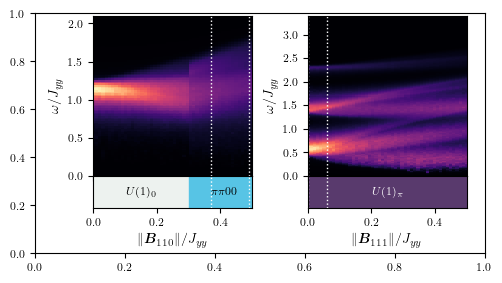

In [67]:
# FIELD SWEEP
fig = plt.figure(figsize=(4.5,2.4))

Ax2 = fig.subplots(2, 2, sharex=True, height_ratios=[2, 0.4])

#  110   111
# [ 0flux , FF ]
# [ ππ00, πflux ]
# [ ππ00-tune, πflux-tune]

# settings=[
#     "?name=0flux?J_pm=-0.046?B=[0.000,0.042,0.042].jld",
#     # "?name=FF-kludge?J_pm=-0.050?B=[0.224,0.224,0.224].jld",
#     "?name=FF-kludge?J_pm=-0.010?B=[0.100,0.100,0.100].jld",
#     "?name=pipi00+1e-4?J_pm=-0.050?B=[0.000,0.260,0.260].jld",
#     "?name=piflux-2?J_pm=0.333?B=[0.058,0.058,0.058].jld"
# ]

settings_sweep = [
    # "int_fieldsweep?name=pipi00-along?J_pm=-0.050?B=[0.577,0.577,0.577].jld",
    # "int_fieldsweep?name=pipi00-along?J_pm=-0.050?B=[0.577,0.577,0.577].jld",
    "int_fieldsweep?name=TEST_mix_pipi00?J_pm=-0.050?B=[0.000,0.000,0.000].jld",
    "int_fieldsweep?name=piflux-along?J_pm=0.333?B=[0.577,0.577,0.577].jld"
]
    

# cmap=matplotlib.cm.gnuplot
cmap=matplotlib.cm.magma
cmap2=cmap
    
Ax2[0][0].set_ylim([0,2.1])
Ax2[0][1].set_ylim([0,3.4])


for s, ax, ax2 in zip(settings_sweep, Ax2[0], Ax2[1]):
    data = h5py.File("output/"+s)
    intens = data['integrated_intensity']
    # print(intens.keys())
    c2 = ax.pcolormesh( intens['magnetic_field_strengths'], intens['W'], intens['Smagnetic'],
                    rasterized=True, 
                       shading='nearest',
                       cmap=cmap2)
    ax.set_facecolor(cmap2(0))
    ax2.set_xlim([np.min(intens['magnetic_field_strengths']), np.max(intens['magnetic_field_strengths'])])

for row in Ax2:

    for b in [0.37, 0.49]:
        row[0].axvline(b,color='w',lw=1,ls=':')

    for b in [0,0.06]:
        row[1].axvline(b,color='w',lw=1,ls=':')


# Ax[0][0].set_title('110 field')
# Ax[0][1].set_title('111 field')

# ax2labels = [r'e) $B\| [110]$', r'f)~~~ $B\|[111]$']
ax2labels = [r'e) ~$J_\pm = -0.05$', r'f) ~$J_\pm = 1/3$']

# for l,ax in zip(ax2labels,Ax2[0]):
#     ax.text(0.05,0.8, l, transform=ax.transAxes, color='white',)


# Ax[0][0].set_ylabel(r"$\omega/J_{yy}$")
# Ax[1][0].set_ylabel(r"$\omega/J_{yy}$")
Ax2[0][0].set_ylabel(r"$\omega/J_{yy}$")
Ax2[0][1].set_ylabel(r"$\omega/J_{yy}$")

phase_colors = dict(
flux0="#EDF2EF",
ππ00="#57C4E5",
πflux="#593a6d",
)

# fig.tight_layout()
# top_top = 0.97
# top_bottom = 0.1
Left = 0.13
Right = 0.96
# subfigs[0].subplots_adjust(top=top_top,right=Right,left=Left,bottom=top_bottom)
# cax = subfigs[0].add_axes([0.9,0.1,0.015,top_top-top_bottom])
# subfigs[0].colorbar(matplotlib.cm.ScalarMappable(cmap=cmap), orientation='vertical', cax=cax)

# Ax2[0][0].axvline(,color='green',lw=1)
bottom_top = 0.99
bottom_bottom = 0.19
# cax2 = subfigs[1].add_axes([0.9,bottom_bottom,0.02,bottom_top-bottom_bottom])
# subfigs[1].colorbar(matplotlib.cm.ScalarMappable(cmap=cmap2), orientation='vertical', cax=cax2)
fig.subplots_adjust(top=bottom_top,right=Right,left=Left,bottom=bottom_bottom,wspace=0.35,hspace=0)

for a in Ax2[1]:
    a.set_yticks([])
    a.set_ylim([0,1])

Bmin = np.sqrt(-9*-0.05/5)
Ax2[1][0].add_patch(matplotlib.patches.Rectangle((0,0), Bmin, 1, color=phase_colors['flux0']))
Ax2[1][0].text(Bmin/2,0.5,r"$U(1)_0$",horizontalalignment="center", verticalalignment="center",fontsize=8)
Ax2[1][0].add_patch(matplotlib.patches.Rectangle((Bmin,0), 1, 1, color=phase_colors['ππ00']))
Ax2[1][0].text(0.41,0.5,r"$\pi\pi00$",horizontalalignment="center", verticalalignment="center",fontsize=8)
Ax2[1][0].set_xlabel(r"$\|\boldsymbol{B}_{110}\|/J_{yy}$")


Ax2[1][1].add_patch(matplotlib.patches.Rectangle((0,0), 1, 1, color=phase_colors['πflux']))
Ax2[1][1].text(0.25,0.5,r"$U(1)_\pi$",horizontalalignment="center", verticalalignment="center",fontsize=8,color='w')
Ax2[1][1].set_xlabel(r"$\|\boldsymbol{B}_{111}\|/J_{yy}$")


fig.savefig(SAVEPATH_POSTER+"/maintext-spinon-sweep.pdf",dpi=300)
fig.add_axes([0,0,1,1]).patch.set_alpha(0)